Authors: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from metadPy import dprime, criterion

# Generate reports and clean data

Individual reports were generated using the following scripts (requires access to the raw data).

In [2]:
#%%capture
#!python reports_HRD.py
#!python reports_HRD2.py

# Del 1 

In [3]:
datapath = os.path.join(
    os.path.abspath(os.path.join(os.getcwd(), os.pardir)),
    'data', 'raw', 'HRD')

outputpath = os.path.join(
    os.path.abspath(os.path.join(os.getcwd(), os.pardir)),
    'data')
session = 'Del1'
subjects = os.listdir(datapath)

After check the individual reports manually, it was decided to remove the following participants from the group analysis.

In [4]:
remove = ['sub_0036', 'sub_0041', 'sub_0054', 'sub_0067', 'sub_0069', 'sub_0078', 'sub_0084', 'sub_0086', 'sub_0139', 'sub_0143', 'sub_0173', 'sub_0234']

Merge dataframes

In [5]:
merged_df = pd.DataFrame([])  # Concatenated raw data
for sub in subjects:
    df = pd.read_csv(os.path.join(datapath, sub, 'filtered.txt'))
    df["Subject"] = sub
    df = df.rename(columns={'Estimation': 'Descision', 'EstimationRT': 'DecisionRT'})
    merged_df = merged_df.append(df, ignore_index=True)

# Remove particpants
for sub_rm in remove:
    merged_df = merged_df[merged_df.Subject != sub_rm]

# Save data frame
merged_df.to_csv(
    os.path.join(
        outputpath, 'Del1_merged.txt'),
    index=False)

In [7]:
merged_df.Subject.nunique()

205

# Del2

This script will import raw data from AUX and build a local database containing only essential files for further preprocessing. You can select where to store these file by changing `localPath`.

In [12]:
datapath = os.path.join(
    os.path.abspath(os.path.join(os.getcwd(), os.pardir)),
    'data', 'raw', 'HRD2')

outputpath = os.path.join(
    os.path.abspath(os.path.join(os.getcwd(), os.pardir)),
    'data')
session = 'Del2'
subjects = os.listdir(datapath)

In [13]:
remove = ['sub_0139']

Merge dataframes

In [14]:
merged_df = pd.DataFrame([])  # Concatenated raw data
for sub in subjects:
    df = pd.read_csv(os.path.join(datapath, sub, 'filtered.txt'))
    df["Subject"] = sub
    merged_df = merged_df.append(df, ignore_index=True)

# Remove particpants
for sub_rm in remove:
    merged_df = merged_df[merged_df.Subject != sub_rm]

# Save data frame
merged_df.to_csv(
    os.path.join(
        outputpath, 'Del2_merged.txt'),
    index=False)

# Summary dataframe

Extract summary statistics

In [15]:
def reversals(df):
    d = np.diff(df.Alpha.to_numpy())
    reversals = d[:-1] != d[1:]
    return np.median(df.Alpha.to_numpy()[1:-1][reversals])

In [16]:
behavior_df = pd.DataFrame([])

for session in ['Del1', 'Del2']:

    group_df = pd.read_csv(
        os.path.join(outputpath, f'{session}_merged.txt'))
 
    for sub in group_df['Subject'].unique():

        taskDuration = (
            group_df.loc[group_df.Subject == sub, "StartListening"].to_numpy()[-1] -
                group_df.loc[group_df.Subject == sub, "StartListening"].to_numpy()[0]
            ) / 60

        for modality in ["Intero", "Extero"]:
            
            threshold, slope, decisionRT, confidenceRT, accuracy, confidence,\
                threshold_updown = None, None, None, None, None, None, None
            
            this_df = group_df[(group_df.Subject == sub) & (group_df.Modality == modality)]

            threshold, slope = (
                this_df[~this_df.EstimatedThreshold.isnull()].EstimatedThreshold.iloc[-1],
                this_df[~this_df.EstimatedSlope.isnull()].EstimatedSlope.iloc[-1],
            )
            decisionRT, confidenceRT = (
                this_df["DecisionRT"].median(),
                this_df.ConfidenceRT.median(),
            )
            accuracy, confidence = (
                this_df["ResponseCorrect"].mean() * 100,
                this_df["Confidence"].mean(),
            )

            # Threshold from up/down staircase
            threshold_updown = np.mean([
                reversals(this_df[this_df.StairCond=='low']),
                reversals(this_df[this_df.StairCond=='high'])
            ])

            # Ratio of staircase corruption
            ratio = ((this_df.Alpha - this_df.EstimatedThreshold).loc[-40:] > 0).mean()
            corruption_ratio = np.abs(ratio-0.5)*2

            behavior_df = behavior_df.append(
                {
                    "Subject": sub,
                    "Session": session,
                    "Modality": modality,
                    "Accuracy": accuracy,
                    "Confidence": confidence,
                    "Threshold": threshold,
                    "Threshold_UpDown": threshold_updown,
                    "Slope": slope,
                    "TaskDuration": taskDuration,
                    "DecisionRT": decisionRT,
                    "ConfidenceRT": confidenceRT,
                    "Corruption": corruption_ratio,
                },
                ignore_index=True,
            )

# Save data frame
behavior_df.to_csv(
    os.path.join(
        outputpath, 'behavior.txt'),
    index=False)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Task descriptive stats

In [11]:
behavior_df = pd.read_csv(os.path.join(outputpath, 'behavior.txt'))

In [12]:
print(f'Number of participants: {len(behavior_df.Subject.unique())}')
del1 = len(behavior_df[behavior_df.Session=='Del1'].Subject.unique())
print(f'Del 1: {del1}')
del2 = len(behavior_df[behavior_df.Session=='Del2'].Subject.unique())
print(f'Del 1: {del2}')

Number of participants: 219
Del 1: 205
Del 1: 187


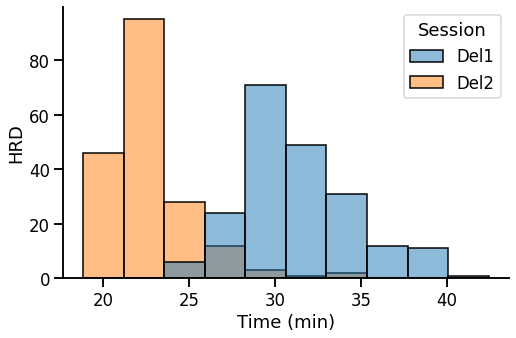

In [13]:
sns.set_context('talk')
plt.figure(figsize=(8, 5))
sns.histplot(data=behavior_df[behavior_df.Modality=='Intero'],
             x='TaskDuration', hue='Session')
plt.xlabel('Time (min)')
plt.ylabel('HRD')
sns.despine()

In [14]:
for session in ['Del1', 'Del2']:
    print(f'Session: {session} - Task mean time: {round(behavior_df[behavior_df.Session == session].TaskDuration.mean(), 2)} min')
    print(f'Session: {session} - Task std time: {round(behavior_df[behavior_df.Session == session].TaskDuration.std(), 2)} min')
    print(f'Session: {session} - Task max time: {round(behavior_df[behavior_df.Session == session].TaskDuration.max(), 2)} min')
    print(f'Session: {session} - Task min time: {round(behavior_df[behavior_df.Session == session].TaskDuration.min(), 2)} min')

Session: Del1 - Task mean time: 31.31 min
Session: Del1 - Task std time: 3.32 min
Session: Del1 - Task max time: 42.46 min
Session: Del1 - Task min time: 24.27 min
Session: Del2 - Task mean time: 22.69 min
Session: Del2 - Task std time: 2.45 min
Session: Del2 - Task max time: 33.81 min
Session: Del2 - Task min time: 18.81 min


## Psi convergence index

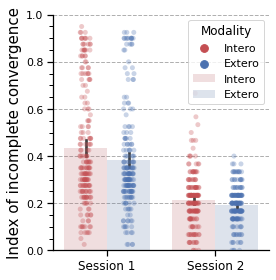

In [50]:
sns.set_context('notebook')
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey='row')

sns.stripplot(data=behavior_df, x='Session', y='Corruption', hue='Modality', dodge=1, edgecolors='k', palette=['#c44e52', '#4c72b0'], linewidths=1, alpha=0.3, ax=ax)
sns.barplot(data=behavior_df, x='Session', y='Corruption', hue='Modality', alpha=0.2, palette=['#c44e52', '#4c72b0'], ax=ax)

plt.xticks([0, 1], ['Session 1', 'Session 2'], size=12)
plt.xlabel('')
ax.minorticks_on()
ax.set_axisbelow(True)
ax.grid(which='major', axis='y',linestyle='--')
ax.tick_params(axis='x', which='minor', bottom=False)
ax.set_ylabel('Index of incomplete convergence', size=15)
ax.set_ylim([0, 1])
plt.tight_layout()
sns.despine()
plt.savefig(os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + f'/figures/Supplement5.svg', dpi=300)